# 4. Bahdanau Attention

## 小结


* 在预测词元时，如果不是所有输入词元都是相关的，那么具有Bahdanau注意力的循环神经网络编码器-解码器会有选择地统计输入序列的不同部分。这是通过将上下文变量视为加性注意力池化的输出来实现的。
* 在循环神经网络编码器-解码器中，Bahdanau注意力将上一时间步的解码器隐状态视为查询，在所有时间步的编码器隐状态同时视为键和值。


## 正文


We studied the machine translation problem in [Section 9.7](https://d2l.ai/chapter_recurrent-modern/seq2seq.html#sec-seq2seq), where we designed an `encoder-decoder` architecture based on two RNNs for sequence to sequence learning. Specifically, the RNN encoder **transforms** a `variable-length sequence` **into** a `fixed-shape context variable`, then the RNN decoder generates the output (target) sequence token by token based on the generated tokens and the context variable. **However**, even though not all the input (source) tokens are useful for decoding a certain token, the **same context variable** that encodes the entire input sequence is still used at each decoding step. (我们需要改变环境变量)

In a separate but related challenge of handwriting generation for a given text sequence, Graves designed a differentiable attention model to align text characters with the much longer pen trace, where the alignment moves only in one direction [[Graves, 2013]](https://d2l.ai/chapter_references/zreferences.html#graves-2013). Inspired by the idea of learning to align, Bahdanau et al. proposed a `differentiable attention model` without the severe unidirectional alignment limitation [[Bahdanau et al., 2014]](https://d2l.ai/chapter_references/zreferences.html#bahdanau-cho-bengio-2014).

- When predicting a token, if not all the input tokens are relevant, the model aligns (or attends) only to **parts of the input sequence that are relevant to the current prediction**. This is achieved by treating the context variable as an output of attention pooling.

## 4.1. Model

When describing **Bahdanau attention** for the RNN encoder-decoder below, we will follow the same notation in [Section 9.7](https://d2l.ai/chapter_recurrent-modern/seq2seq.html#sec-seq2seq). The new attention-based model is the same as that in [Section 9.7](https://d2l.ai/chapter_recurrent-modern/seq2seq.html#sec-seq2seq) except that the context variable $c$ in [(9.7.3)]() is replaced by $c_t^′$ at any decoding time step $t^′$. Suppose that there are $T$ tokens in the input sequence, the context variable at the decoding time step $t^′$ is the output of attention pooling:

$$
c_t^′=\sum_{t=1}^T\alpha(s_{t^′−1},h_t)h_t,
$$

where the **decoder** hidden state $s_{t^′−1}$ at time step $t^′−1$ is the `query`, and the **encoder** hidden states ht are both the `keys` and `values`, and the attention weight $\alpha$ is computed as in [(3.2)](./3_Attention_Scoring_Functions.md) using the **additive attention scoring function** defined by [(3.3)]().

Slightly different from the vanilla RNN encoder-decoder architecture in [Fig. 9.7.2](), the same architecture with **Bahdanau attention** is depicted in [Fig. 4.1]().

<center>
    <img style="border-radius: 0.3125em;
    box-shadow: 0 2px 4px 0 rgba(34,36,38,.12),0 2px 10px 0 rgba(34,36,38,.08);" 
    src="https://d2l.ai/_images/seq2seq-attention-details.svg" width = "75%" alt=""/>
    <br>
    <div style="color:orange; border-bottom: 1px solid #d9d9d9;
    display: inline-block;
    color: #999;
    padding: 2px;">
      Fig 4.1 Layers in an RNN encoder-decoder model with Bahdanau attention.
  	</div>
</center>

In [1]:
import torch
import numpy as np
from torch import nn
from d2l_en.pytorch.d2l import torch as d2l
from C10_3_Attention_Scoring_Function import AdditiveAttention

## 4.2. Defining the Decoder with Attention

To implement the RNN encoder-decoder with Bahdanau attention, we **only need to redefine** the `decoder`. To visualize the learned attention weights more conveniently, the following `AttentionDecoder` class defines the base interface for decoders with attention mechanisms.

In [2]:
class AttentionDecoder(d2l.Decoder):
    """ The base Attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property # 创建只读属性，@property装饰器会将方法转换为相同名称的只读属性,可以与所定义的属性配合使用，这样可以防止属性被修改。
    def attention_weights(self):
        raise NotImplementedError

Now let us implement the RNN decoder with Bahdanau attention in the following `Seq2SeqAttentionDecoder` class. The state of the decoder is initialized with

* (i) the encoder **final-layer hidden states** at all the time steps (as `keys` and `values` of the attention);

- (ii) the encoder all-layer hidden state at **the final time step** (to initialize the hidden state of the decoder);
- (iii) the encoder **valid length** (to exclude the padding tokens in attention pooling).

At each decoding time step, the decoder final-layer hidden state at the previous time step is used as the query of the attention. As a result, both the attention output and the input embedding are concatenated as the input of the RNN decoder.

In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = AdditiveAttention(
            num_hiddens, num_hiddens, num_hiddens, dropout
        )
        self.embbeding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(
            embed_size + num_hiddens, num_hiddens, num_layers, dropout=dropout
        )
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        """
        :param enc_outputs:
        :param enc_valid_lens:
        :param args:
        :return:
        """
        outputs, hidden_state = enc_outputs
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        #  Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        """

        :param X:
        :param state:
        :return:
        """
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        X = self.embbeding(X).permute(1, 0, 2
                                      )# Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        outputs, self._attention_weights = [], []
        for x in X:
            query = torch.unsqueeze(hidden_state[-1], dim=1
                                    ) # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(
                query, enc_outputs, enc_outputs, enc_valid_lens
            ) # Shape of `context`: (`batch_size`, 1, `num_hiddens`)

            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)),
                          dim=-1)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), # reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
                                         hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)

        outputs = self.dense(torch.cat(outputs, dim=0))# shape of `outputs`:  (`num_steps`, `batch_size`, `vocab_size`)
        return outputs.permute(1, 0, 2), [enc_outputs, hidden_state,
                                          enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we test the implemented decoder with Bahdanau attention using a minibatch of 4 sequence inputs of 7 time steps.

In [6]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16,
                             num_layers=2)
encoder.eval()
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16,
                                  num_layers=2)
decoder.eval()
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

## 4.3. Training

Similar to [Section 9.7.4](https://d2l.ai/chapter_recurrent-modern/seq2seq.html#sec-seq2seq-training), here we specify hyperparemeters, instantiate an encoder and a decoder with Bahdanau attention, and train this model for machine translation. Due to the newly added attention mechanism, this training is much slower than that in [Section 9.7.4](https://d2l.ai/chapter_recurrent-modern/seq2seq.html#sec-seq2seq-training) without attention mechanisms.

loss 0.021, 6769.8 tokens/sec on cuda:0


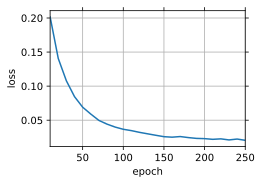

In [4]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(
    len(src_vocab), embed_size, num_hiddens, num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(
    len(tgt_vocab), embed_size, num_hiddens, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

After the model is trained, we use it to translate a few English sentences into French and compute their BLEU scores.

In [7]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est paresseux .,  bleu 0.658
i'm home . => je suis chez moi .,  bleu 1.000


In [8]:
attention_weights = torch.cat([step[0][0][0] for step in dec_attention_weight_seq], 0).reshape((
    1, 1, -1, num_steps))

By visualizing the attention weights when translating the last English sentence, we can see that each query assigns non-uniform weights over key-value pairs. It shows that at each decoding step, different parts of the input sequences are selectively aggregated in the attention pooling.

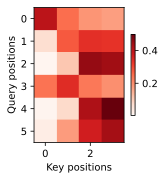

In [9]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')